In [1]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# import dependencies
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
class_names = list(Base.classes.keys())

# print results
print(class_names)


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session from Python to the DB
session = Session(engine)

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# print results
most_recent_date


'2017-08-23'

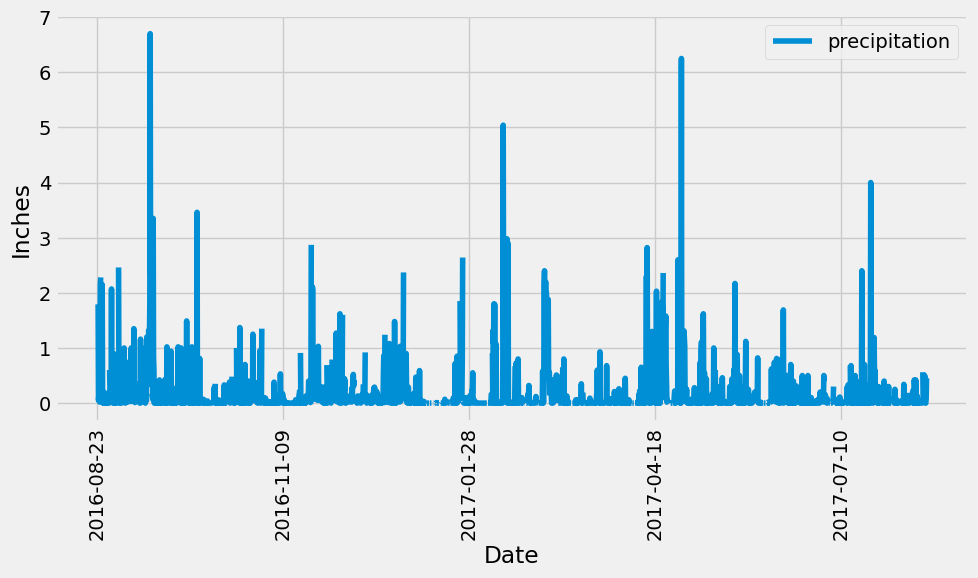

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date one year from the last date in data set.
last_date_obj = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
one_year_ago = last_date_obj - dt.timedelta(days=365)

# Performs a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a dataframe setting columns name
prcp_df = pd.DataFrame(results, columns=['Date', 'precipitation'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date')

# Plotting the data
prcp_df.plot(x='Date', y='precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
# calculating the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()

# print results
print(summary_stats)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


In [14]:
# Query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
result = [(total_stations,)]

# print results
print(result)


[(9,)]


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
result = [(station, count) for station, count in active_stations]

# print results
for row in result:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# performs query to calculate the min, max, and avg temp observations from the Measurement table
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# print results
print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


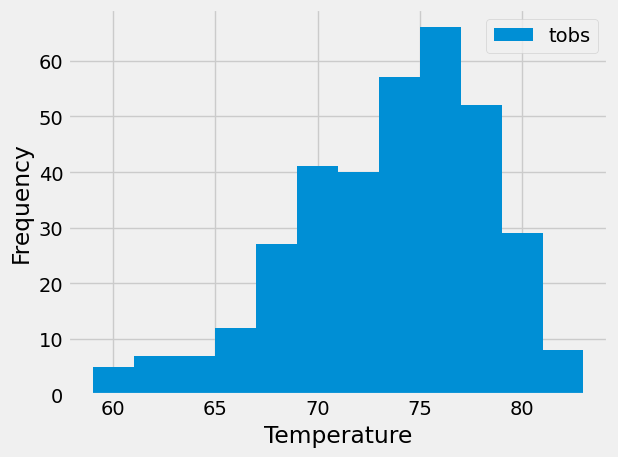

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Retrieve the last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date one year ago from the last date
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query temperature data for the most active station within the last year
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Extract temperatures from the temperature data
temperatures = [temp[0] for temp in temperature_data]

# Plot a histogram for the temps
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Close Session
session.close()